# Time Series Forecasting
- First step in regressive sequence prediction technuique
- Will move to group by hour and predict hourly high and low

In [173]:
!pip install tqdm==4.59.0 --quiet

In [174]:
!pip install pytorch-lightning==1.2.5 --quiet

In [175]:
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [176]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] =12, 8

tqdm.pandas()

In [177]:
pl.seed_everything(42)

Global seed set to 42


42

## Data Preprocessing
- Data scrpaed from crypotodatadownload.com
- We will sort values by thje data and create a rolling close price difference column
- Convert unix to datetime and extract day, week, month columns
- Create a new features and target dataset
- Split the data into train, val, and test splits
- Scale training data features and labels only to prevent val, test data mean and std leakage during transform
  - Optimization for stochastic gradient decent
  - Faster convergeance 
  - Combat against vanishing gradient
- Create data sequences to feed the model

In [314]:
# Examine scraped data
df = pd.read_csv('/content/drive/MyDrive/1. Full Projects/Multivariate Time Series/datasets/Binance_XRPUSDT_minute.csv', header=1, parse_dates=['date'])
df = df.sort_values(by='date').reset_index(drop=True)
df.head(10)

,unix,date,symbol,open,high,low,close,Volume XRP,Volume USDT,tradecount
0,1578298860000,2020-01-06 08:21:00,XRP/USDT,0.197,0.197,0.197,0.197,6111.6,1203.9852,2
1,1578298920000,2020-01-06 08:22:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0
2,1578298980000,2020-01-06 08:23:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0
3,1578299040000,2020-01-06 08:24:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0
4,1578299100000,2020-01-06 08:25:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0
5,1578299160000,2020-01-06 08:26:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0
6,1578299220000,2020-01-06 08:27:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0
7,1578299280000,2020-01-06 08:28:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0
8,1578299340000,2020-01-06 08:29:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0
9,1578299400000,2020-01-06 08:30:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0


In [249]:
df.shape

(997868, 10)

In [250]:
# Rolling close change window as additional feature
df['prev_close'] = df.shift(1)['close']

df['close_change'] = df.progress_apply(
    lambda row: 0 if np.isnan(row['prev_close']) else row.close - row['prev_close'],
    axis=1
)

df.head()

  0%|          | 0/997868 [00:00<?, ?it/s]

,unix,date,symbol,open,high,low,close,Volume XRP,Volume USDT,tradecount,prev_close,close_change
0,1578298860000,2020-01-06 08:21:00,XRP/USDT,0.197,0.197,0.197,0.197,6111.6,1203.9852,2,NaN,0.0
1,1578298920000,2020-01-06 08:22:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0,0.197,0.0
2,1578298980000,2020-01-06 08:23:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0,0.197,0.0
3,1578299040000,2020-01-06 08:24:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0,0.197,0.0
4,1578299100000,2020-01-06 08:25:00,XRP/USDT,0.197,0.197,0.197,0.197,0.0,0.0000,0,0.197,0.0


In [253]:
# Exctracting date features
features_df = df.copy()
features_df['day_of_week'] = features_df['date'].dt.dayofweek
features_df['day_of_month'] = features_df['date'].dt.day
features_df['week_of_year'] = features_df['date'].dt.week
features_df['month'] = features_df['date'].dt.month

features_df.drop(['unix', 'date', 'symbol', 'Volume XRP',	'Volume USDT', 'prev_close', 'tradecount'], axis=1, inplace=True)
features_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


,open,high,low,close,close_change,day_of_week,day_of_month,week_of_year,month
0,0.197,0.197,0.197,0.197,0.0,0,6,2,1
1,0.197,0.197,0.197,0.197,0.0,0,6,2,1
2,0.197,0.197,0.197,0.197,0.0,0,6,2,1
3,0.197,0.197,0.197,0.197,0.0,0,6,2,1
4,0.197,0.197,0.197,0.197,0.0,0,6,2,1


In [255]:
features_df.shape

(997868, 9)

In [256]:
# Splitting the data into train, val, and test
train_size = int(len(features_df) * 0.8)
val_test_size = int(len(features_df) * 0.2)
test_size =  int(val_test_size / 2)

train_df, val_test_df = features_df[ : train_size+1], features_df[train_size: ]

val_df, test_df = val_test_df[:test_size+1], val_test_df[test_size:]

train_df.shape, val_df.shape, test_df.shape

((798295, 9), (99787, 9), (99788, 9))

In [257]:
# Fitting the scaler training data
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(train_df)

In [258]:
# Converting scale transformed np.array back into dataframe  
scaled_train_df = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

scaled_val_df = pd.DataFrame(
    scaler.transform(val_df),
    index=val_df.index,
    columns=val_df.columns
)

scaled_test_df = pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns
)

In [259]:
scaled_train_df.head()

,open,high,low,close,close_change,day_of_week,day_of_month,week_of_year,month
0,-0.900345,-0.901176,-0.89724,-0.900242,0.278589,-1.0,-0.666667,-0.961538,-1.0
1,-0.900345,-0.901176,-0.89724,-0.900242,0.278589,-1.0,-0.666667,-0.961538,-1.0
2,-0.900345,-0.901176,-0.89724,-0.900242,0.278589,-1.0,-0.666667,-0.961538,-1.0
3,-0.900345,-0.901176,-0.89724,-0.900242,0.278589,-1.0,-0.666667,-0.961538,-1.0
4,-0.900345,-0.901176,-0.89724,-0.900242,0.278589,-1.0,-0.666667,-0.961538,-1.0


In [260]:
def create_sequences(input_data: pd.DataFrame, target_column, seq_len):
  sequences = []
  data_size = len(input_data)

  # Excluding final sequence to avoid len error
  for i in tqdm(range(data_size - seq_len)):
    # Exclusive indexing
    sequence = input_data[i:i+seq_len]
    # Inclusive indexing 
    label_position = i + seq_len
    # Indexing the label of the preceeding row as the target
    label = input_data.iloc[label_position][target_column]

    # return tuple of sequnces and target
    sequences.append((sequence, label))

  return sequences

In [261]:
SEQ_LEN = 120

# Creating sequences with succeeding rows close price as target
train_sequences = create_sequences(scaled_train_df, 'close', SEQ_LEN)
val_sequences = create_sequences(scaled_val_df, 'close', SEQ_LEN)
test_sequences = create_sequences(scaled_test_df, 'close', SEQ_LEN)

  0%|          | 0/798175 [00:00<?, ?it/s]

  0%|          | 0/99667 [00:00<?, ?it/s]

  0%|          | 0/99668 [00:00<?, ?it/s]

In [262]:
# Sanity Check
# Indexing the final row of the second sequence
train_sequences[1][0].loc[120]

open           -0.877876
high           -0.877973
low            -0.876343
close          -0.879280
close_change    0.270073
day_of_week    -1.000000
day_of_month   -0.666667
week_of_year   -0.961538
month          -1.000000
Name: 120, dtype: float64

In [263]:
# The target value for the first sequence
train_sequences[0][1]

-0.8792804123600519

In [264]:
train_sequences[0][0].shape

(120, 9)

In [265]:
len(train_sequences), len(val_sequences), len(test_sequences)

(798175, 99667, 99668)

In [266]:
len(train_df) - len(train_sequences) == SEQ_LEN

True

# Pytorch Data Prerequisites 
- Pytorch dataset class module - convert features and target to tenors
  - Sanity check
- Pytoerch lighting datamodule - dataloader to feed the data to the model in batches
  - Sanity check

In [272]:
# Creating a pytorch tensor dataset class
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class TensorDataset(Dataset):

  def __init__(self, sequences):
    self.sequences = sequences
  # The __len__ function returns the number of samples in our dataset
  def __len__(self):
    return len(self.sequences)

  # The __getitem__ function loads and returns a sample from the dataset at the given index idx
  def __getitem__(self, idx):
    # Extracting sequence and label from tuple input
    sequence, label = self.sequences[idx]

    # Converting features from pandas dataframe to numpy array and wrapping in tensor constructor
    # Converting labels into float and wrapping in tensor contructor
    return dict(
        sequence = torch.Tensor(sequence.to_numpy()),
        label = torch.tensor(label).float()
    )

In [276]:
train_dataset = TensorDataset(train_sequences)

In [277]:
for item in train_dataset:
  print(item['sequence'].shape)
  print(item['label'].shape)
  print(item['label'])
  break

torch.Size([120, 9])
torch.Size([])
tensor(-0.8793)


In [283]:
# Wrapping the pytorch tensor datasets into lightning datamodule
# https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html
class StockPriceDataModule(pl.LightningDataModule):

  def __init__(
      self, train_sequences, val_sequences, test_sequences, batch_size = 8
  ):
    # Super contructor of the lightning module
    super().__init__()
    # Loading the sequnces 
    self.train_sequences = train_sequences
    self.val_sequences = val_sequences
    self.test_sequences = test_sequences
    self.batch_size = batch_size
  
  # Passing the pytorch tensor datasets 
  def setup(self):
    self.train_dataset = TensorDataset(self.train_sequences)
    self.val_dataset = TensorDataset(self.val_sequences)
    self.test_dataset = TensorDataset(self.test_sequences)

  # Shuffle False for time series - in this case, can experiment with this parameter
  def train_dataloader(self):
    return DataLoader(
    self.train_dataset,
    batch_size = self.batch_size,
    shuffle = False,
    num_workers = 2
  )
  
  # Batch size 1 for val and test
  def val_dataloader(self):
    return DataLoader(
    self.val_dataset,
    batch_size = 1,
    shuffle = False,
    num_workers = 1
  )

  def test_dataloader(self):
    return DataLoader(
    self.test_dataset,
    batch_size = 1,
    shuffle = False,
    num_workers = 1
  ) 

# Training Variables
- Epochs and batch size
- Data module sanity check


In [284]:
N_EPOCHS = 8
# Overwriting the batch size from datamodule
BATCH_SIZE = 64

data_module = StockPriceDataModule(train_sequences, val_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

In [285]:
for item in data_module.train_dataloader():
  print(item['sequence'].shape)
  print(item['label'].shape)
  break

torch.Size([64, 120, 9])
torch.Size([64])


# LSTM Model Constructor
- Creating LSTM model using Pytorch nn.modeule
- Optional feature dimension, hidden, and LSTM layer counts
- Output nn.Linear regressor

# Lightning Training Module
- Extracting boilerplate 
- Automating optimization of weights, back-propagation, gradients etc...  
- Sanity check

In [286]:
# https://pytorch.org/docs/stable/generated/torch.nn.Module.html
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
class PricePredictionModel(nn.Module):

  def __init__(self, n_features: int, n_hidden: int, n_layers: int):
    super().__init__()

    self.n_hidden = n_hidden

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        # Stacking LSTM layers
        num_layers = n_layers,
        dropout = 0.2
    )
    # Converts hidden layer output and returns single number 
    self.regressor = nn.Linear(n_hidden, 1)
  
  # Optional tp optimize for potential disributed training 
  # https://discuss.pytorch.org/t/why-do-we-need-flatten-parameters-when-using-rnn-with-dataparallel/46506
  def forward(self, x):
    self.lstm.flatten_parameters()
    # Extracting the entire hidden state
    _, (hidden, _) = self.lstm(x)
    # Extracting the output of the final layer of the hidden state
    out = hidden[-1]
    # Passing final hidden state output to regressor
    return self.regressor(out)


In [288]:
class StockPricePredictor(pl.LightningModule):

  def __init__(self, n_features: int, n_hidden: int, n_layers: int):
    super().__init__()
    # Passing the parameters to the pl.modeul instance
    self.model = PricePredictionModel(n_features, n_hidden, n_layers)
    self.criterion = nn.MSELoss()
  
  def forward(self, x, labels=None):
    output = self.model(x)
    loss = 0
    if labels is not None:
      # Adding a dimension to the labels to match the output
      loss = self.criterion(output, labels.unsqueeze(dim=1))
    return loss, output

  def training_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    self.log('train_loss', loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    self.log('val_loss', loss, prog_bar=True, logger=True)
    return loss
   
  def test_step(self, batch, batch_idx):
    sequences = batch['sequence']
    labels = batch['label']
    loss, outputs = self(sequences, labels)
    self.log('test_loss', loss, prog_bar=True, logger=True)
    return loss
  
  def configure_optimizers(self):
    return optim.AdamW(self.parameters(), lr=0.0001)


In [289]:
model = StockPricePredictor(n_features = train_df.shape[1], n_hidden=128, n_layers=2)

# Pytroch Lightning Trainer 
- Checkpoints, Logger, & Early Stopping
- Defineing filepaths
- Number of checkpoints to save
- Log training
- Fit trainer

# Model Training

In [291]:
# Save best model only
checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/1. Full Projects/Multivariate Time Series/checkpoints/fri_3_12/",
    filename="best-checkpoint",
    save_top_k = 1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("/content/drive/MyDrive/1. Full Projects/Multivariate Time Series/lightning_logs", name="xrp-price")

# Montior val_loss
# Patience = 2 epochs
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback = checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs = N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Checkpoint directory /content/drive/MyDrive/1. Full Projects/Multivariate Time Series/checkpoints/fri_3_12/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [310]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 203 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
203 K     Trainable params
0         Non-trainable params
203 K     Total params
0.814     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 12471it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 7, step 112247: val_loss was not in top 1


1

In [293]:
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.003738489467650652}
--------------------------------------------------------------------------------


[{'test_loss': 0.003738489467650652}]

# Best Model Checkpoint
- Loading the trained model
- Freezing the model weights
- Predicting on the test set

In [316]:
# Reloading the model with the same parameters
trained_model = BTCPricePredictor.load_from_checkpoint(
    "/content/drive/MyDrive/1. Full Projects/Multivariate Time Series/checkpoints/fri_3_12/best-checkpoint.ckpt",
    n_features=train_df.shape[1],
    n_hidden = 128, 
    n_layers = 2
)

In [317]:
# Prevents the weights of a neural network layer from being modified
trained_model.freeze()

In [318]:
# Creating Pytorch tensor dataset from the test sequence sacaled at teh beginning of the notebook
test_dataset = BTCDataset(test_sequences)

In [319]:
# Iterating over the dataset
predictions = []
labels = []

for item in tqdm(test_dataset):
  # Extracting sequnce and label from dict output
  sequence = item['sequence']
  label = item['label']

  # Extracting the output from the modeland appending to lists
  _, output = trained_model(sequence.unsqueeze(dim=0))
  predictions.append(output.item())
  labels.append(label.item())

  0%|          | 0/99668 [00:00<?, ?it/s]

In [330]:
len(predictions), len(test_df) - SEQ_LEN

(99668, 99668)

In [332]:
test_sequences[0][0].tail()

,open,high,low,close,close_change,day_of_week,day_of_month,week_of_year,month
898195,-0.114174,-0.114233,-0.109519,-0.112824,0.285888,0.333333,0.533333,0.423077,0.454545
898196,-0.112884,-0.114126,-0.109304,-0.113469,0.274939,0.333333,0.533333,0.423077,0.454545
898197,-0.113529,-0.113804,-0.108873,-0.112931,0.281630,0.333333,0.533333,0.423077,0.454545
898198,-0.112991,-0.114019,-0.108765,-0.113146,0.277372,0.333333,0.533333,0.423077,0.454545
898199,-0.113206,-0.114341,-0.109412,-0.113899,0.274331,0.333333,0.533333,0.423077,0.454545


In [333]:
labels[0], predictions[0]

(-0.11368387937545776, -0.18104226887226105)

# Descaling Predicted Close Price
- Invereting the Min Max scaling on close proce for predictions and labels
- https://stackoverflow.com/questions/49330195/how-to-use-inverse-transform-in-minmaxscaler-for-a-column-in-a-matrix

In [334]:
scaler.min_[3], scaler.scale_[3]

(-1.112012297703318, 1.0749740662506517)

In [335]:
# Overwtiting the descaler parameters with the scale params at label column index
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[3], scaler.scale_[3]

def descale(descaler, values):
  # Converting the output values parameters from 1D to 2D 
  values_2d = np.vstack(values)
  # Output a vector
  return descaler.inverse_transform(values_2d).flatten()

In [336]:
predictions_descaled = descale(descaler, predictions) 
labels_descaled = descale(descaler, labels)

In [337]:
predictions_descaled[:5]

array([0.86603952, 0.86602936, 0.86572361, 0.86530498, 0.8648904 ])

In [338]:
labels_descaled[:5]

array([0.9287, 0.9276, 0.927 , 0.9266, 0.927 ])

In [339]:
# Creating a new unscaled test datasetbeginning at the first prediction
test_sequences_data = df.iloc[train_size+test_size+SEQ_LEN:]
len(test_sequences_data), len(test_sequences)

(99668, 99668)

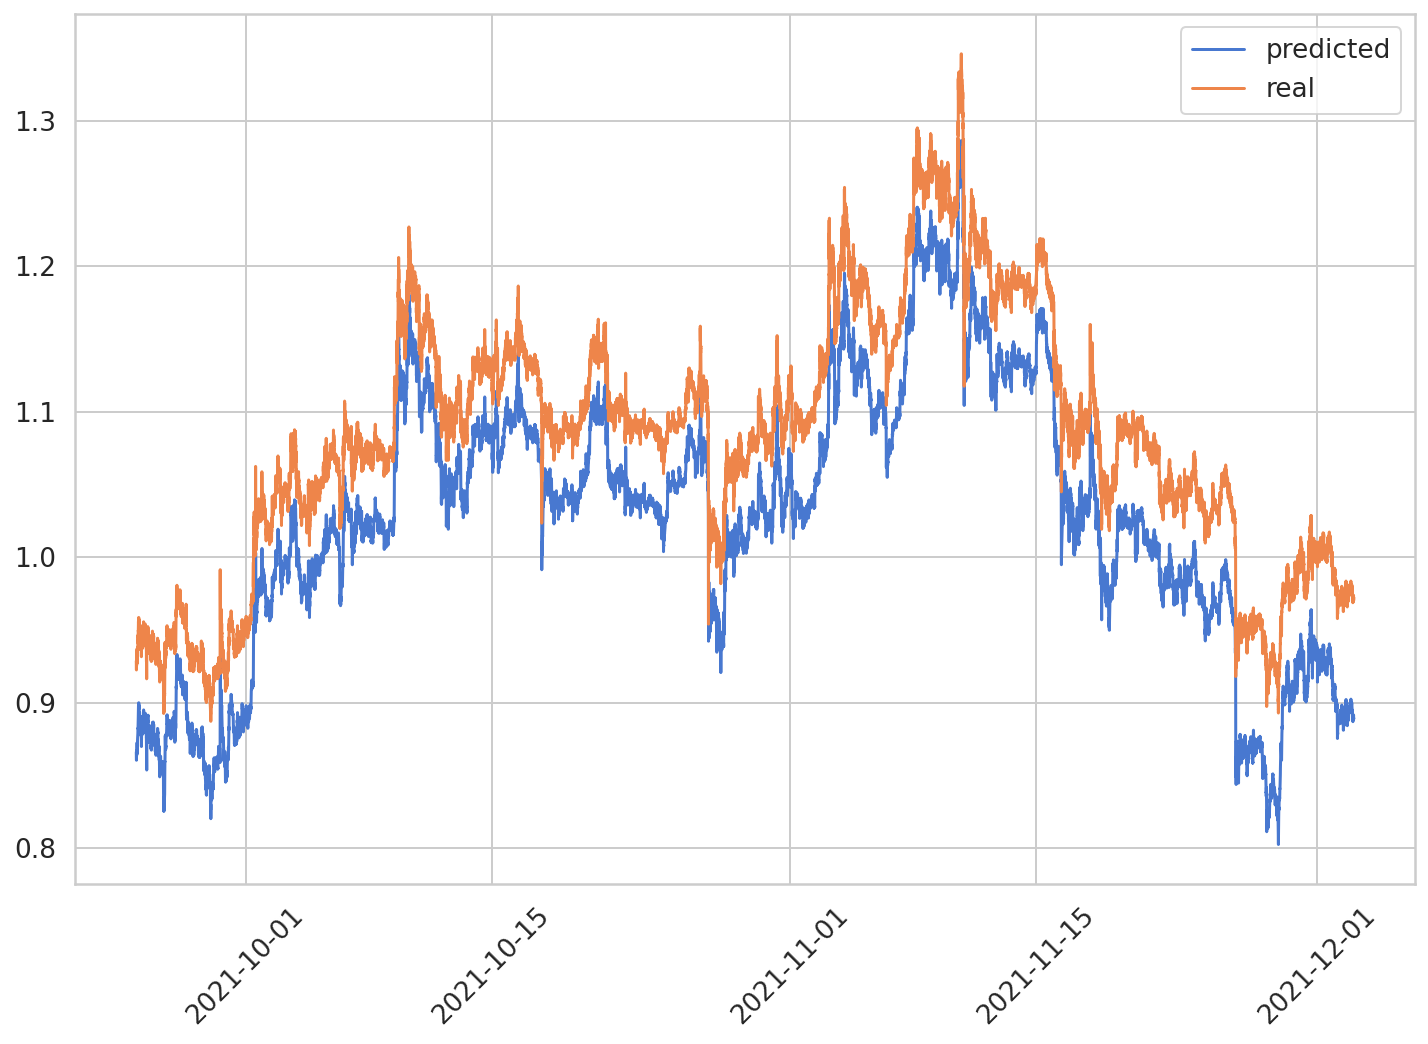

In [340]:
dates = plt.matplotlib.dates.date2num(test_sequences_data.date.tolist())
plt.plot_date(dates, predictions_descaled, '-', label='predicted')
plt.plot_date(dates, labels_descaled, '-', label='real')
plt.xticks(rotation=45)
plt.legend()
plt.show()